In [93]:
!pip install -e /Users/lars/devel/tpk4170-robotics/

Obtaining file:///Users/lars/devel/tpk4170-robotics
  Found existing installation: tpk4170 1.0
    Uninstalling tpk4170-1.0:
      Successfully uninstalled tpk4170-1.0
  Running setup.py develop for tpk4170


In [183]:
import os
from glob import glob

In [184]:
import numpy as np
np.set_printoptions(suppress=True)
import cv2 as cv

In [185]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 150

In [213]:
from tpk4170.visualization import Viewer
from tpk4170.models import Grid, Axes
from tpk4170.utils.transformations import quaternion_from_matrix
from tpk4170.utils import splitfn

# Camera calibration
Adapted from the camera calibration tutorial found [here](https://docs.opencv.org/3.4.3/dc/dbb/tutorial_py_calibration.htm).

## Goals
You will learn about:
1. types of distortion caused by cameras
2. how to find the intrinsic and extrinsic properties of a camera
3. how to undistort images based off these properties

## Basics
Some pinhole cameras introduce significant distortion to images. Two major kinds of distortion are:
- **radial distortion** 
- **tangential distortion**.

### Radial distortion

Radial distortion causes straight lines to appear curved. Radial distortion becomes larger the farther points are from the center of the image. 

For example, one image is shown below in which two edges of a chess board are marked with red lines. But, you can see that the border of the chess board is not a straight line and doesn't match with the red line. All the expected straight lines are bulged out. 

![](https://docs.opencv.org/3.4.3/calib_radial.jpg)

Radial distortion can be represented as follows:
\begin{align}
x_{\text{distorted}} &= x( 1 + k_1 r^2 + k_2 r^4 + k_3 r^6) \\ 
y_{\text{distorted}} &= y( 1 + k_1 r^2 + k_2 r^4 + k_3 r^6)
\end{align}

### Tangential distortion
Tangential distortion occurs because the image-taking lense is not aligned perfectly parallel to the imaging plane. So, some areas in the image may look nearer than expected. The amount of tangential distortion can be represented as below:
\begin{align}
x_{\text{distorted}} &= x + [ 2p_1xy + p_2(r^2+2x^2)] \\ 
y_{\text{distorted}} &= y + [ p_1(r^2+ 2y^2)+ 2p_2xy]
\end{align}

### Distortion coefficients
In short, we need to find five parameters, known as distortion coefficients given by:
```python
dist_coeffs = [k1, k2, p1, p2, k3]
```

### Camera parameters

You alse need to some other information, like the **intrinsic** and **extrinsic** parameters of the camera. 

Intrinsic parameters are specific to a camera. They include information like focal length $(f_x, f_y)$ and optical centers $(c_x,c_y)$. The focal length and optical centers can be used to create a camera matrix, which can be used to remove distortion due to the lenses of a specific camera. The camera matrix is unique to a specific camera, so once calculated, it can be reused on other images taken by the same camera. It is expressed as a 3x3 matrix:

\begin{align}
K = \left [ \begin{matrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{matrix} \right ]
\end{align}

Extrinsic parameters corresponds to rotation and translation vectors which translates a coordinates of a 3D point to a coordinate system.

To find these parameters, we must provide some sample images of a well defined pattern (e.g. a chess board). We find some specific points of which we already know the relative positions (e.g. square corners in the chess board). We know the coordinates of these points in real world space and we know the coordinates in the image, so we can solve for the distortion coefficients. For better results, we need at least 10 test patterns.

## Code

We need at least 10 test patterns for camera calibration. OpenCV comes with some images of a chess board.

Consider an image of a chess board. The important input data needed for calibration of the camera is the set of 3D real world points and the corresponding 2D coordinates of these points in the image. These image points are locations where two black squares touch each other on the chess board.

The images are taken from a static camera and chess boards are placed at different locations and orientations. We need to know (X,Y,Z) values. For simplicity, we can say chess board was kept stationary at XY plane, (so Z=0 always) and camera was moved accordingly. This consideration helps us to find only X,Y values. Now for X,Y values, we can simply pass the points as (0,0), (1,0), (2,0), ... which denotes the location of points. 

In this case, the results we get will be in the scale of size of chess board square. But if we know the square size, (say 30 mm), we can pass the values as (0,0), (30,0), (60,0), ... . Thus, we get the results in mm. In this case, we don't know square size since we didn't take those images, so we pass in terms of square size.

3D points are called **object points** and 2D image points are called **image points**.

### Load image file names

In [187]:
img_mask = './images/left??.jpg'
img_names = glob(img_mask)
print(img_names)

['./images/left09.jpg', './images/left08.jpg', './images/left14.jpg', './images/left01.jpg', './images/left03.jpg', './images/left02.jpg', './images/left12.jpg', './images/left06.jpg', './images/left07.jpg', './images/left13.jpg', './images/left05.jpg', './images/left11.jpg', './images/left04.jpg']


### Create object points
Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)

In [217]:
# square_size = 1
square_size = 0.05
pattern_size = (9, 6)
pattern_points = np.zeros((np.prod(pattern_size), 3), np.float32)
pattern_points[:, :2] = np.indices(pattern_size).T.reshape(-1, 2)
pattern_points *= square_size
print(pattern_points[34:40])

[[0.35 0.15 0.  ]
 [0.4  0.15 0.  ]
 [0.   0.2  0.  ]
 [0.05 0.2  0.  ]
 [0.1  0.2  0.  ]
 [0.15 0.2  0.  ]]


### Process image

To find a chess board pattern, we can use the function `cv.findChessboardCorners()`. 

We need to pass what kind of pattern we are looking for, like 8x8 grid, 5x5 grid etc. In this example, we use 9x6 grid. It returns the corner points and retval which will be True if the pattern is obtained. These corners will be placed in an order from left-to-right and top-to-bottom.

In [218]:
def process_image(fn, debug=False):

    #  Read image from file
    img = cv.imread(fn, 0)
    if img is None:
        print("Failed to load", fn)
        return None

    #  Locate chessboard corners in images
    found, corners = cv.findChessboardCorners(img, pattern_size)
    if found:
        term = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_COUNT, 30, 0.001)
        cv.cornerSubPix(img, corners, (5, 5), (-1, -1), term)

    #  Debug: Draw chessboard on image
    if debug:
        vis = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
        cv.drawChessboardCorners(vis, pattern_size, corners, found)
        _path, name, _ext = splitfn(fn)
        outfile = os.path.join(_path, name + '_chess.png')
        cv.imwrite(outfile, vis)

    #  Return None if the chessboard is not founf
    if not found:
        print('Chessboard not found')
        return None

    #  Print status
    print('{}... OK'.format(fn))

    return (corners.reshape(-1, 2), pattern_points)

In [219]:
chessboards = [process_image(fn, debug=True) for fn in img_names]
chessboards = [x for x in chessboards if x is not None]

./images/left09.jpg... OK
./images/left08.jpg... OK
./images/left14.jpg... OK
./images/left01.jpg... OK
./images/left03.jpg... OK
./images/left02.jpg... OK
./images/left12.jpg... OK
./images/left06.jpg... OK
./images/left07.jpg... OK
./images/left13.jpg... OK
./images/left05.jpg... OK
./images/left11.jpg... OK
./images/left04.jpg... OK


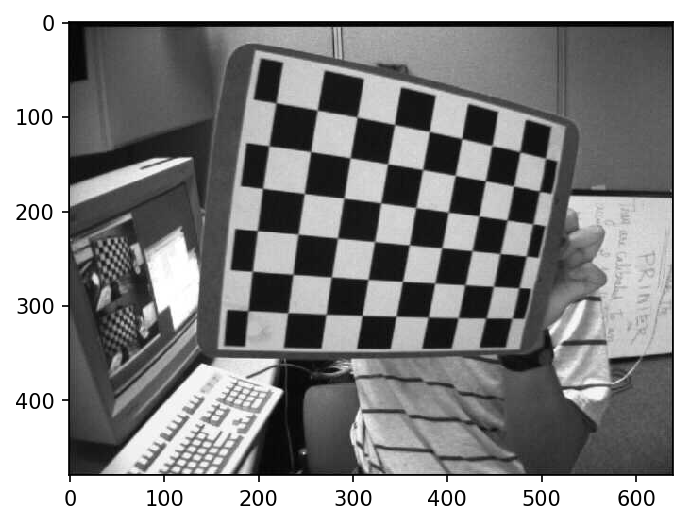

In [220]:
img = cv.imread('./images/left09.jpg')
plt.imshow(img);

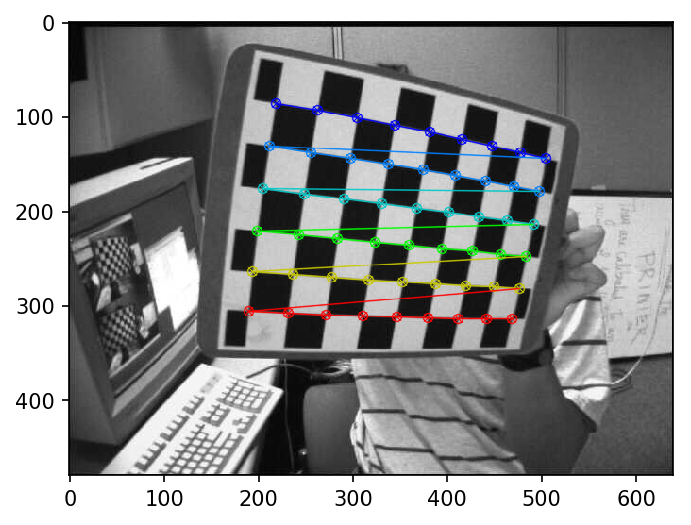

In [221]:
img_chess = cv.imread('./images/left09_chess.png')
plt.imshow(img_chess);

In [222]:
# Split image points and objects points
img_points = []
obj_points = []
for (corners, pattern_points) in chessboards:
    img_points.append(corners)
    obj_points.append(pattern_points)

In [223]:
# Find the size of the image
img_size = cv.imread(img_names[0], 0).shape[:2]
print(img_size)

(480, 640)


### Calibrate the camera parameters

In [224]:
rms, camera_matrix, dist_coeffs, rvecs, tvecs = cv.calibrateCamera(obj_points, img_points, img_size, None, None)

#### RMS

In [225]:
print(rms)

0.19543361854678637


#### Camera matrix

In [226]:
print(camera_matrix)

[[532.82708686   0.         342.48678964]
 [  0.         532.94586425 233.8559549 ]
 [  0.           0.           1.        ]]


#### Distortion coefficients

In [227]:
print(dist_coeffs.ravel())

[-0.2808806   0.02516945  0.00121658 -0.00013555  0.16345279]


### Undistort

In [228]:
# undistort
img_undistorted = cv.undistort(img, camera_matrix, dist_coeffs, None, new_camera_matrix)

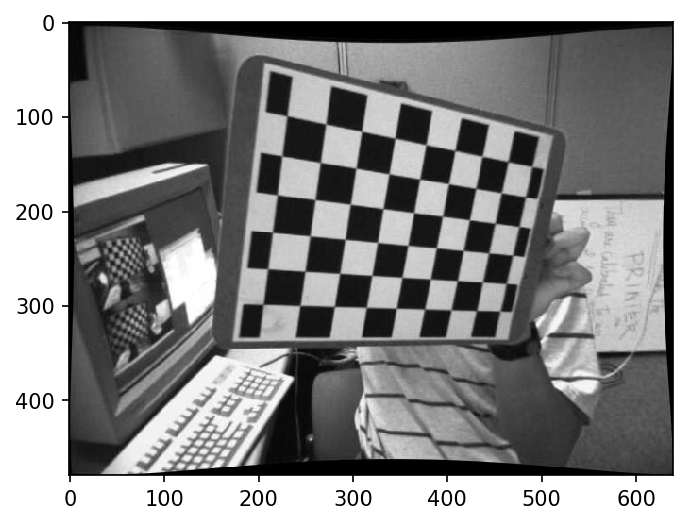

In [229]:
plt.imshow(img_undistorted);

### Reprojection error

In [230]:
img_points2, _ = cv.projectPoints(obj_points[0], rvecs[0], tvecs[0], camera_matrix, dist_coeffs)
img_points2 = img_points2.reshape(-1,2)

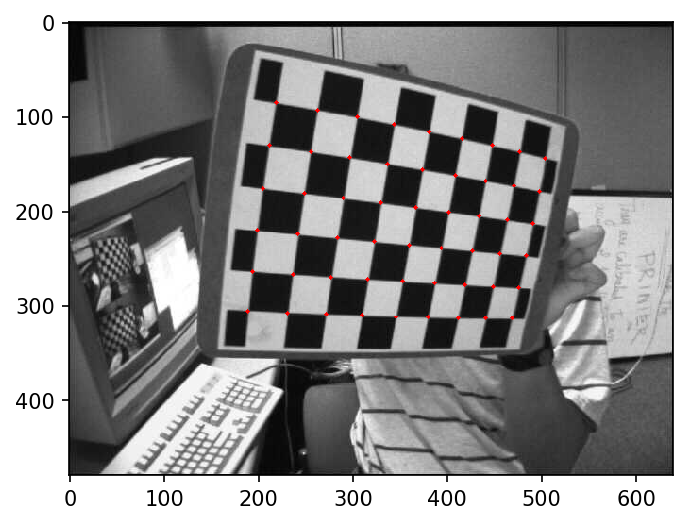

In [231]:
img_repr = img.copy()
for (cx, cy) in img_points2:
    img_repr = cv.circle(img_repr, (cx, cy), 2, (255,0,0), -1)
plt.imshow(img_repr);

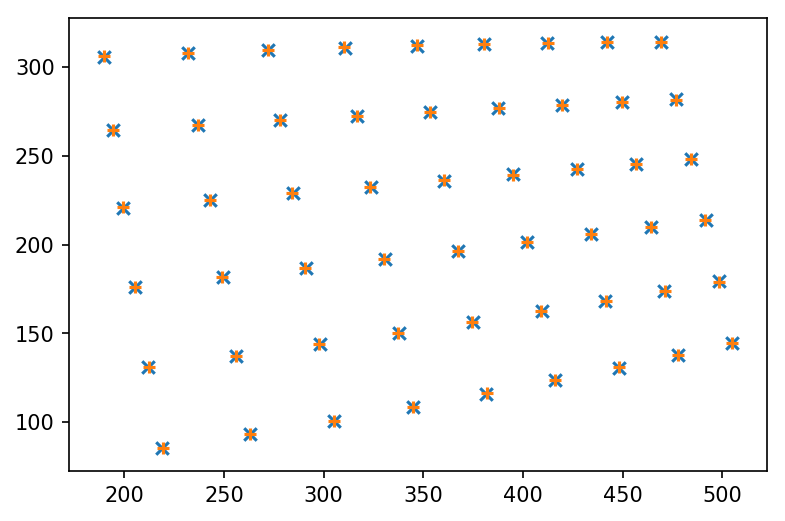

In [232]:
plt.scatter(img_points[0][:,0], img_points[0][:,1], marker='x');
plt.scatter(img_points2[:,0], img_points2[:,1], marker='+');

In [233]:
reprojection_errors = []
for i in range(len(obj_points)):
    img_points2, _ = cv.projectPoints(obj_points[i], rvecs[i], tvecs[i], camera_matrix, dist_coeffs)
    img_points2 = img_points2.reshape(-1,2)
    reprojection_error = img_points[i] - img_points2
    reprojection_errors.append(reprojection_error)

In [234]:
tot_error = 0
for i in range(len(obj_points)):
    img_points2, _ = cv.projectPoints(obj_points[i], rvecs[i], tvecs[i], camera_matrix, dist_coeffs)
    img_points2 = img_points2.reshape(-1,2)
    error = cv.norm(img_points[i], img_points2, cv.NORM_L2) / len(img_points2)
    tot_error += error
print("error: ", tot_error / len(obj_points))

error:  0.026417668782049396


In [239]:
### Show extrinsic parameters

In [240]:
vis = Viewer()
vis.add(Grid())
vis.add(Axes(0.3))

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(color='white', intensity=0.66, positi…

In [242]:
for rvec, tvec in zip(rvecs, tvecs):
    axes = Axes(0.3)
    R = np.eye(4)
    R[:3, :3] = cv.Rodrigues(rvec)[0]
    axes.quaternion = quaternion_from_matrix(R).tolist()
    axes.position = tvec.ravel().tolist()
    vis.add(axes)